In [1]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR, $IMAGEN_PROJECT_DIR & $INPUT_DIR

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.formula.api as smf
import pickle
import statsmodels.stats.multitest
import sklearn.utils
from tqdm import tqdm

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
}
INPUT_DIR = os.environ["INPUT_DIR"]
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)

from utils import transform, plot, stats, datasets
from modeling.check_fit import *

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({"font.size": 16, "font.family": "Asana Math", "figure.dpi": 192})
thcolor = "#44546A"

/data/project/ei_development/env/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Load optimal simulations, demographics and other data needed:

In [3]:
itMax = 81
lmbda = 210
params = {
    "G": "0.5-4",
    "wee": "0.05-0.75",
    "wei": "0.05-0.75",
    "wie": "0",
}
het_params = "wee-wei"
n_vols_remove = 10  # = 30s

elig_subs = pd.read_csv(
    os.path.join(INPUT_DIR, "pnc_subs.csv"), index_col=0
).sort_index()
parcels = transform.load_ordered_parcel_labels("schaefer-100")

In [4]:
if os.path.exists("pnc_fc-sub_sc-sub_runs-2.csv") & os.path.exists(
    "pnc_fc-sub_sc-sub_runs-2_vars.pkz"
):
    # load pre-curated data if it exists
    subjects_optima = pd.read_csv("pnc_fc-sub_sc-sub_runs-2.csv", index_col=0)
    with open("pnc_fc-sub_sc-sub_runs-2_vars.pkz", "rb") as f:
        regional_vars = pickle.load(f)
else:
    subjects_optima = []
    regional_vars = {}
    for sub in tqdm(elig_subs.index):
        cmaes_dir = os.path.join(
            OUTPUT_DIR["pnc"], 'sim', sub, 
            'ctx_parc-schaefer-100_mean001_thresh-1', 
            '6maps_schaefer-100_zscore',
            'cmaes_multimaps_gpu'
        )
        sims_dir = cmaes_dir.replace("cmaes_multimaps_gpu", "sims_multimaps_gpu")
        sc_path = os.path.join(
            OUTPUT_DIR["pnc"], 'SC', sub,
            'ctx_parc-schaefer-100_mean001_thresh-1_desc-strength.txt'
        )
        maps_path = os.path.join(INPUT_DIR, '6maps_schaefer-100_zscore.txt')
        emp_fc_tril_path = os.path.join(
            OUTPUT_DIR["pnc"], 'FC', sub,
            'ctx_parc-schaefer-100_hemi-LR_highpass-013_lowpass-none_exc-inter_desc-FCtril.txt'
        )
        emp_fcd_tril_path = emp_fc_tril_path.replace('FCtril', 'FCDtril')
        emp_fc_tril = np.loadtxt(emp_fc_tril_path)
        emp_fcd_tril = np.loadtxt(emp_fcd_tril_path)
        regional_vars[sub] = {}
        for SeedMW in [1, 2]:
            cmaes_res = load_cmaes(
                cmaes_dir,
                sims_dir,
                params,
                het_params,
                maps_path,
                emp_fc_tril,
                emp_fcd_tril,
                sc_path=sc_path,
                n_vols_remove=n_vols_remove,
                itMax=itMax,
                lmbda=lmbda,
                SeedMW=SeedMW,
                dataset="pnc",
            )
            if cmaes_res:
                cmaes_res[0]["sub"] = sub
                cmaes_res[0]["SeedMW"] = SeedMW
                subjects_optima.append(cmaes_res[0])
                regional_vars[sub][SeedMW] = cmaes_res[1]
    subjects_optima = pd.DataFrame(subjects_optima)
    subjects_optima.to_csv("pnc_fc-sub_sc-sub_runs-2.csv")
    with open("pnc_fc-sub_sc-sub_runs-2_vars.pkz", "wb") as f:
        pickle.dump(regional_vars, f)

Select the best run in each subject and add the demographics and motion measures to the data:

In [5]:
best_runs = subjects_optima.groupby("sub")["gof"].idxmax().values
data = subjects_optima.loc[best_runs].set_index("sub")
data[["age", "sex", "group"]] = elig_subs.loc[data.index, ["age", "sex", "group"]]
data["Age (y)"] = data["age"] / 12

# add motion data
motion = pd.read_csv(
    os.path.join(OUTPUT_DIR["pnc"], 'postfmriprep', 'participants.tsv'), 
    delimiter="\t", index_col=0
).loc[data.index]
data = pd.concat([data, motion], axis=1)

Create a dataframe of regional $\langle I^E \rangle$ in each subject:

In [6]:
I_E = pd.DataFrame(index=data.index, columns=parcels, dtype=float)
for i, parc in enumerate(parcels):
    for sub, row in data.iterrows():
        I_E.loc[sub, parc] = regional_vars[sub][row["SeedMW"]].loc[i, "I_E"]

# Figure 2. Cross-sectional effect of age on excitation-inhibition balance during adolescence

Apply the linear regression model:

In [7]:
df = pd.concat([I_E, data], axis=1)
df.columns = [f"node_{i}" for i in range(100)] + list(df.columns[100:])

t_age = pd.Series(index=parcels)
r_age = pd.Series(index=parcels)
p_age = pd.Series(index=parcels)

for i, parc in enumerate(parcels):
    # exclude outliers
    curr_subs = I_E.index[(scipy.stats.zscore(I_E.loc[:, parc]).abs() < 3)]
    model_df = df.loc[curr_subs]
    # fit the confound removal model to calculate pearson's r of the
    # residual of I_E with age as an easy-to-interpret effect size
    res_conf = smf.ols(f"node_{i} ~ gof + sex + mean_rms", data=model_df).fit()
    r_age.loc[parc] = scipy.stats.pearsonr(model_df["age"], res_conf.resid).statistic
    # fit the main model
    mod = smf.ols(f"node_{i} ~ age + gof + sex + mean_rms", data=model_df)
    res = mod.fit()
    t_age.loc[parc] = res.tvalues["age"]
    p_age.loc[parc] = res.pvalues["age"]

# FDR correction
_, p_age_fdr = statsmodels.stats.multitest.fdrcorrection(p_age)
p_age_fdr = pd.Series(p_age_fdr, index=parcels)

# display stats of signficant regions
stats_age = pd.DataFrame({"t": t_age, "r": r_age, "p": p_age, "p_fdr": p_age_fdr})
stats_age[stats_age["p_fdr"] < 0.05].sort_values(by="t").round(3)

,t,r,p,p_fdr
7Networks_RH_Cont_Par_1,-7.330,-0.255,0.000,0.000
7Networks_LH_Cont_pCun_1,-6.957,-0.242,0.000,0.000
7Networks_RH_Cont_PFCl_1,-6.946,-0.243,0.000,0.000
7Networks_RH_Default_Par_1,-6.342,-0.222,0.000,0.000
7Networks_RH_Cont_PFCl_4,-6.133,-0.215,0.000,0.000
7Networks_RH_Default_PFCdPFCm_3,-5.987,-0.211,0.000,0.000
7Networks_RH_Cont_Par_2,-5.750,-0.204,0.000,0.000
7Networks_LH_Limbic_OFC_1,-5.253,-0.187,0.000,0.000
7Networks_LH_Default_PFC_3,-5.158,-0.183,0.000,0.000
7Networks_LH_Default_PFC_7,-5.144,-0.182,0.000,0.000


In [8]:
stats_age.to_csv("p_pnc_fc-sub_sc-sub_runs-2_IE_age_stats.csv")

## a. Effect of age on $\langle I_i^E \rangle$ (FDR-corrected)

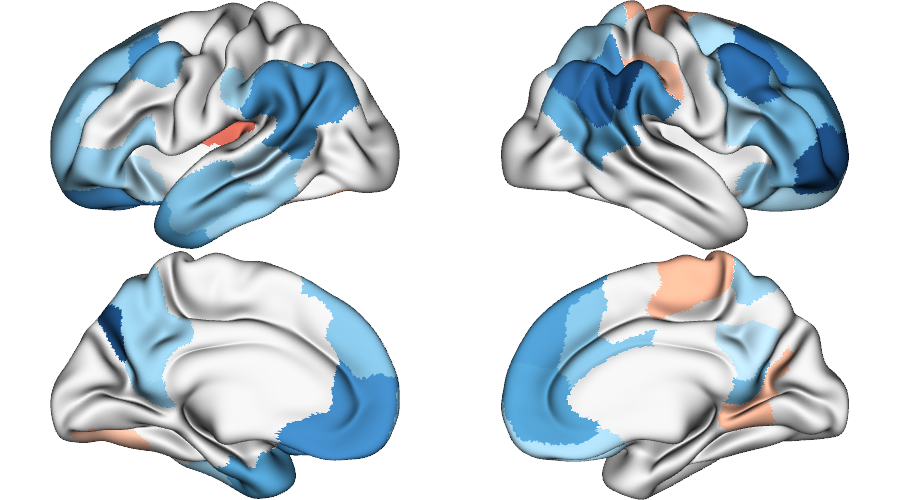

In [10]:
plot.plot_surface(
    transform.deparcellate_surf(
        t_age[p_age_fdr < 0.05], "schaefer-100", concat=True, space="fsaverage"
    ),
    "fsaverage",
    mesh_kind="semi-inflated",
    vrange="sym",
    cmap="RdBu_r",
    cbar=False,
    layout_style="grid",
)

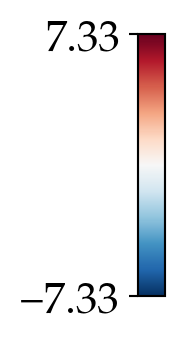

In [11]:
vmin = min(t_age.values.min(), -t_age.values.max())
vmax = -vmin
plot.plot_colorbar(vmin.round(2), vmax.round(2), "RdBu_r", figsize=(2, 2));

## b. Effect of age on $\langle I_i^E \rangle$ (unthresholded)

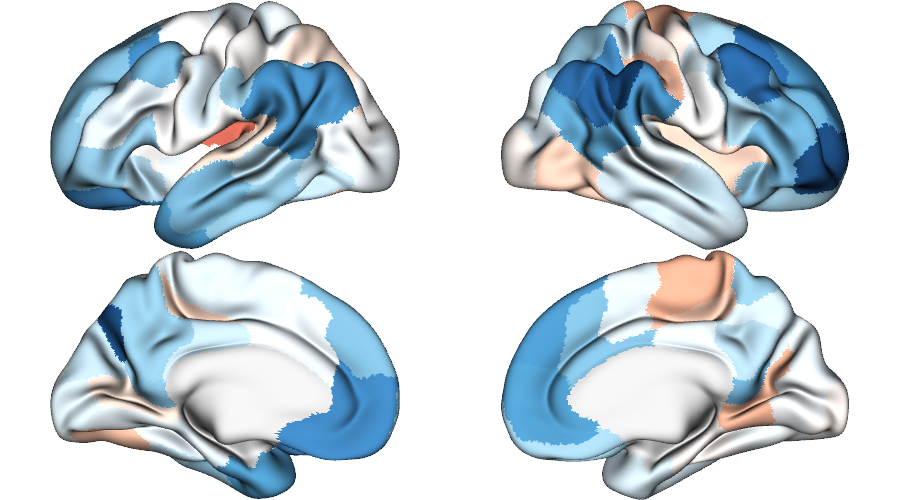

In [12]:
plot.plot_surface(
    transform.deparcellate_surf(t_age, "schaefer-100", concat=True, space="fsaverage"),
    "fsaverage",
    mesh_kind="semi-inflated",
    vrange="sym",
    cmap="RdBu_r",
    cbar=False,
    layout_style="grid",
)

## c. Stability of age effect map across subsamples of subjects

Calculate age effects in 100 half-split subsamples of subjects:

In [25]:
# add age bin to stratify subsamples based on age and sex
df["age_bin"] = pd.cut(df["Age (y)"], 10)

n_subsamples = 100
n_samples = df.shape[0] // 2
print("Using n_samples", n_samples)

t_subsamples = pd.DataFrame(index=parcels, columns=range(n_subsamples), dtype=float)
p_subsamples = pd.DataFrame(index=parcels, columns=range(n_subsamples), dtype=float)

for subsample in tqdm(range(n_subsamples)):
    # creating half-split subsamples without replacement
    # using subsample index as random_state for reproducibility
    subsample_df = sklearn.utils.resample(
        df,
        replace=False,
        n_samples=n_samples,
        random_state=subsample,
        stratify=df[["sex", "age_bin"]],
    )
    # calculate age effect in current subsample
    for i, parc in enumerate(parcels):
        curr_subs = subsample_df.index[
            (scipy.stats.zscore(subsample_df.loc[:, f"node_{i}"]).abs() < 3)
        ]
        model_df = subsample_df.loc[curr_subs]
        mod = smf.ols(f"node_{i} ~ age + gof + sex + mean_rms", data=model_df)
        res = mod.fit()
        t_subsamples.loc[parc, subsample] = res.tvalues["age"]
        p_subsamples.loc[parc, subsample] = res.pvalues["age"]

Using n_samples 376


100%|███████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


Calculate and plot the correlation between age effect maps calculated across subsamples:

In [29]:
subsamples_corr = np.corrcoef(t_subsamples.values.T)
subsamples_corr = subsamples_corr[np.tril_indices_from(subsamples_corr, -1)]

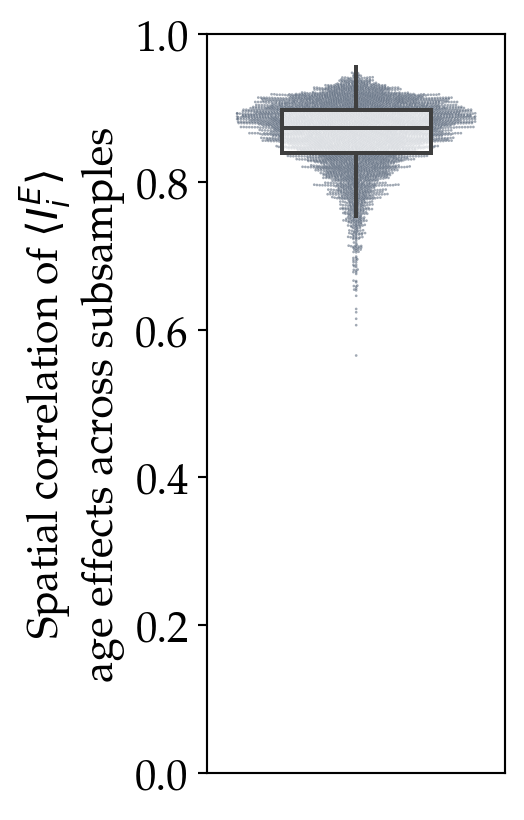

In [43]:
fig, ax = plt.subplots(figsize=(2, 5))
sns.swarmplot(y=subsamples_corr, color=thcolor, s=1, alpha=0.5, ax=ax)
sns.boxplot(
    data=subsamples_corr,
    showfliers=False,
    showcaps=False,
    width=0.5,
    boxprops={"facecolor": (1, 1, 1, 0.75)},
    ax=ax,
)
plt.setp(ax.collections, zorder=0, label="")  # puts swarm in the back
ax.set_ylabel(
    r"Spatial correlation of $\langle I_i^E \rangle$" "\nage effects across subsamples"
)
ax.set_ylim([0, 1])
ax.set_xticks([]);

In [14]:
pd.Series(subsamples_corr).describe()

count    4950.000000
mean        0.863443
std         0.046771
min         0.565003
25%         0.839607
50%         0.872839
75%         0.896785
max         0.954899
dtype: float64

## Text. Age-by-sex intercation

In [13]:
t_age_sex = pd.Series(index=parcels, dtype=float)
p_age_sex = pd.Series(index=parcels, dtype=float)
for i, parc in enumerate(parcels):
    curr_subs = df.index[(scipy.stats.zscore(df.loc[:, f'node_{i}']).abs() < 3)]
    model_df = df.loc[curr_subs]
    mod = smf.ols(f'node_{i} ~ sex*age + gof + mean_rms', data=model_df)
    res = mod.fit()
    t_age_sex.loc[parc] = res.tvalues['sex[T.M]:age']
    p_age_sex.loc[parc] = res.pvalues['sex[T.M]:age']

# FDR correction
_, p_age_sex_fdr = statsmodels.stats.multitest.fdrcorrection(p_age_sex)
p_age_sex_fdr = pd.Series(p_age_sex_fdr, index=parcels)

# display effect of signficant regions
t_age_sex[p_age_sex_fdr<0.05].sort_values()

Series([], dtype: float64)

# Figure S2. Goodness-of-fit measures in PNC dataset

## a. Distributions

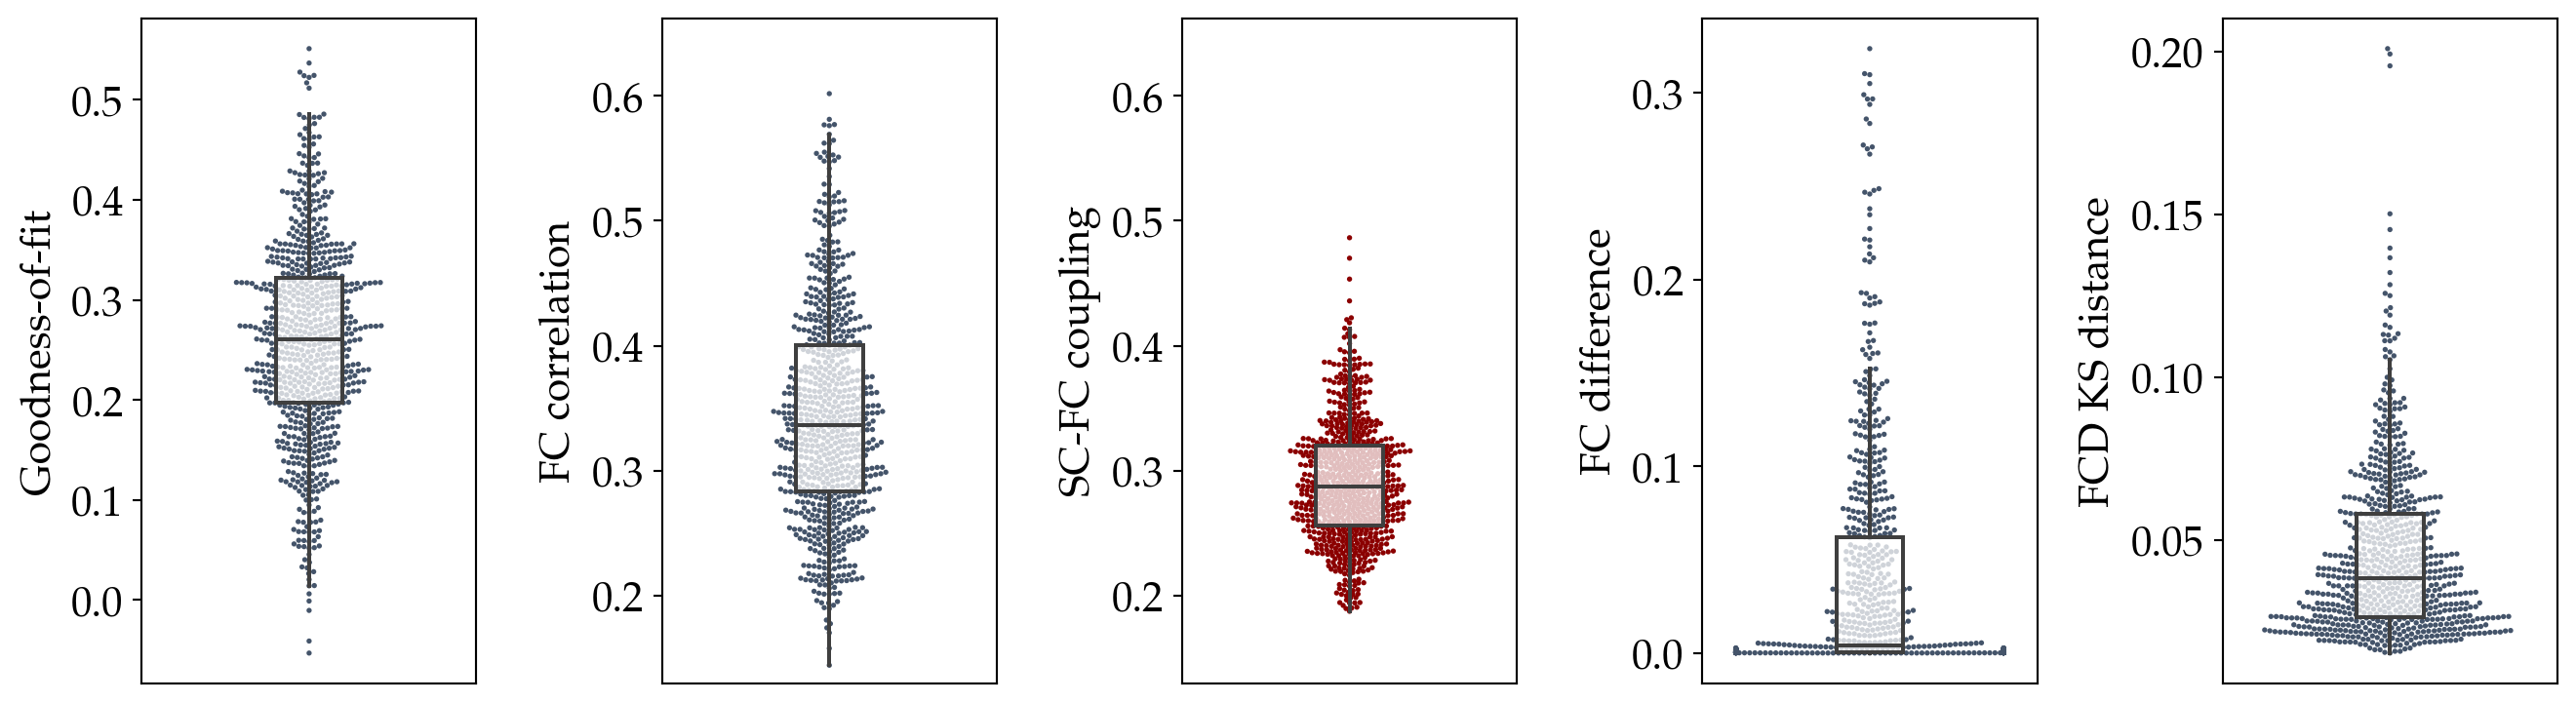

In [17]:
gof_labels = {
    "gof": "Goodness-of-fit",
    "fc_corr": "FC correlation",
    "sc_fc": "SC-FC coupling",
    "fc_diff": "FC difference",
    "fcd_ks": "FCD KS distance",
}

fig, axes = plt.subplots(1, len(gof_labels), figsize=(14, 4))
for i, (col, label) in enumerate(gof_labels.items()):
    ax = axes[i]
    if col != "sc_fc":
        color = thcolor
    else:
        color = "darkred"
    sns.swarmplot(y=data[col], s=2, color=color, ax=ax)
    sns.boxplot(
        data=data[col],
        showfliers=False,
        showcaps=False,
        width=0.2,
        boxprops={"facecolor": (1, 1, 1, 0.75)},
        ax=ax,
    )
    plt.setp(ax.collections, zorder=0, label="")  # puts swarm in the back
    ax.set_ylabel(label)
    ax.set_xticks([])
    if col in ["sc_fc", "fc_corr"]:
        ax.set_ylim(
            [
                data[["sc_fc", "fc_corr"]].values.min() * 0.9,
                data[["sc_fc", "fc_corr"]].values.max() * 1.1,
            ]
        )
fig.tight_layout(pad=1.0)

In [18]:
data[list(gof_labels.keys())].describe().round(3)

,gof,fc_corr,sc_fc,fc_diff,fcd_ks
count,752.000,752.000,752.000,752.000,752.000
mean,0.259,0.344,0.291,0.040,0.045
std,0.101,0.085,0.048,0.063,0.026
min,-0.053,0.144,0.188,0.000,0.015
25%,0.197,0.283,0.256,0.001,0.026
50%,0.260,0.337,0.287,0.004,0.038
75%,0.322,0.400,0.320,0.062,0.058
max,0.551,0.602,0.486,0.324,0.201


## b. Age variation

Goodness-of-fit	0.062	0.09
FC correlation	-0.073	0.044
SC-FC coupling	-0.129	0.0
FC difference	-0.182	0.0
FCD KS distance	-0.039	0.287


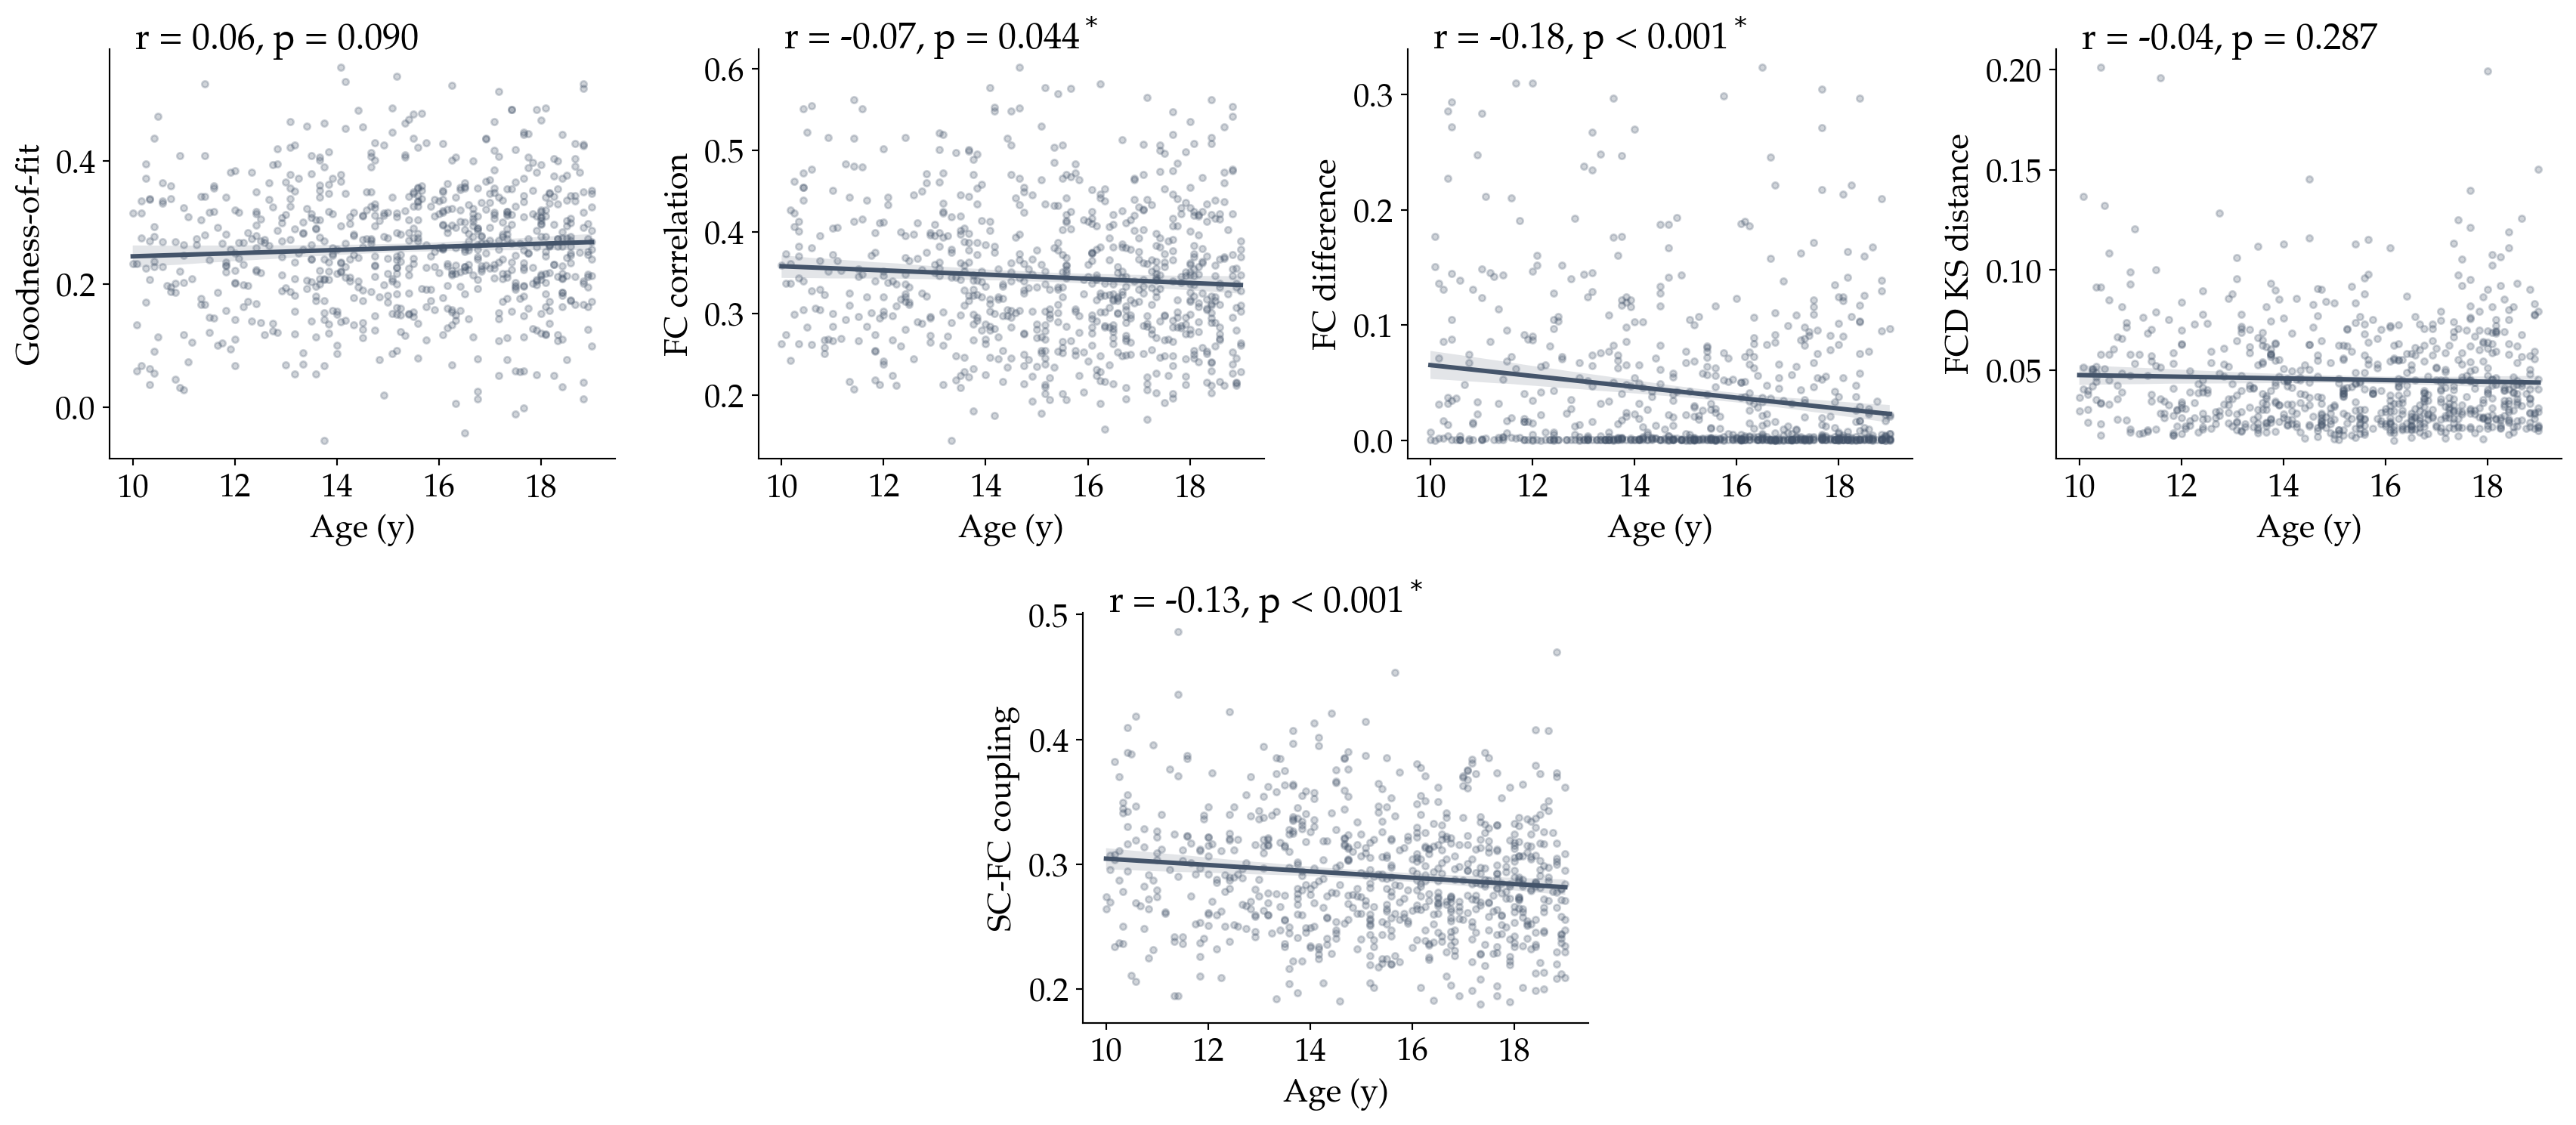

In [67]:
fig, axd = plt.subplot_mosaic(
    [
        ["gof"] * 2 + ["fc_corr"] * 2 + ["fc_diff"] * 2 + ["fcd_ks"] * 2,
        ["emp_left"] * 3 + ["sc_fc"] * 2 + ["emp_right"] * 3,
    ],
    gridspec_kw=dict(width_ratios=[1] * 8, height_ratios=[1] * 2),
    figsize=(18, 8),
)
axd["emp_left"].axis("off")
axd["emp_right"].axis("off")
add_text = True
for col, label in gof_labels.items():
    # plot
    ax = axd[col]
    sns.regplot(
        x=data["Age (y)"],
        y=data[col],
        scatter_kws=dict(color=thcolor, alpha=0.25, s=10),
        line_kws=dict(color=thcolor),
        ax=ax,
    )
    sns.despine()
    # stats
    r, p = scipy.stats.pearsonr(data["Age (y)"], data[col])
    if add_text:
        if p > 0.001:
            text = f"r = {r:.2f}, p = {p:.3f}"
        else:
            text = f"r = {r:.2f}, p < 0.001"
        if p < 0.05:
            text += r"$^*$"
        text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
        text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 1
        ax.text(text_x, text_y, text, color="black", size=18, multialignment="left")
    ax.set_ylabel(label)
    print(label, round(r, 3), round(p, 3), sep="\t")
fig.tight_layout(pad=1.0)